## Learning to Rank

Pointwise: One instance of the set is considered at a time, use any kind of classifier or regressor to predict how relevant it is in the current query. Use each points predicted relevance to order the set.

Pairwise: A pair of instances is chosen and the order of those two is predicted. Repeat this for each pair of the query to find the final order of the entire query.

Listwise: Many or all instances are considered at once. Try to find the optimal order.

- https://www.kaggle.com/code/prashant111/lightgbm-classifier-in-python
- https://www.kaggle.com/code/samratp/lightgbm-xgboost-catboost
- https://developer.nvidia.com/blog/learning-to-rank-with-xgboost-and-gpu/#:~:text=XGBoost%20is%20a%20widely%20used,descent%20using%20an%20objective%20function.
- https://medium.com/predictly-on-tech/learning-to-rank-using-xgboost-83de0166229d

In [1]:
#pip install catboost

In [2]:
import pandas as pd
import numpy as np

from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_error

import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers



import matplotlib.pyplot as plt
import seaborn as sns


2022-06-04 17:37:06.694439: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-04 17:37:06.694497: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Data Preparation (Pre-processing)

In [3]:
import pandas as pd

df = pd.read_csv('hotels3.csv')
df.head()

,Hotel,Star,Rating,Reviews,Harga,Places Nearby,Facil + Akomod
0,Hotel Indonesia Kempinski Jakarta,5.0,8.9,4363,2.480.500,Nearby Places\n\nJia Jia - Grand Indonesia (De...,Food and Drinks\nA la carte breakfast\nA la ca...
1,"The Langham, Jakarta",5.0,8.8,238,3.823.600,Nearby Places\n\nPig Me Up! - Ashta District 8...,Food and Drinks\nA la carte dinner\nA la carte...
2,Manhattan Hotel,5.0,8.5,8405,6.231.500,Nearby Places\n\nJia Jia - Grand Indonesia (De...,Hotel Services\nBellhop\nConcierge\nMoney chan...
3,Aloft South Jakarta,4.0,8.9,424,762.300,Nearby Places\n\nSouthside Rooftop Bar & Loung...,Public Facilities\nParking\nCoffee shop\nEleva...
4,"The Mayflower, Jakarta - Marriott Executive Ap...",5.0,9.0,393,1.756.254,Nearby Places\n\nSudirman Plaza\nBusiness\n2 m...,Food and Drinks\nA la carte breakfast\nA la ca...


In [4]:
facilities_columns = ['Food and Drinks','Hotel Services','In-room Facilities', 'Business Facilities', 'Nearby Facilities', 'Public Facilities', 'General', 'Things to Do', 'Accessibilty', 'Connectivity', 'Transportation', 'Kids and Pets', 'Sports and Recreations', 'Shuttle Service']

facilities_columns.reverse()

for index , row in df.iterrows():
    
    # split per fasil and akomod
    arr = row['Facil + Akomod'].splitlines() 
    #iterate over fasil and akomod

    i = 0
    count = 0

    for  item in reversed(arr):
      count += 1
      if item in facilities_columns:
        df.at[index,item ] = count
        count = 0
        i += 1

In [5]:
df = df.fillna(0)

In [6]:
for index , row in df.iterrows():
    
    # split per fasil and akomod
    arr = row['Places Nearby'].splitlines() 
    
    #iterate over fasil and akomod

    i = 0
    count = 0
    
    for ind, item in enumerate(arr):
        itemsplits = item.split()
        for x in itemsplits:
            if x.isdigit():
                if itemsplits[1] == "km":
                    meters = itemsplits[0] * 1000
                else:
                    meters = itemsplits[0]
                    
                if meters.isdigit():
                    df.at[index,arr[ind-1]] = meters
                    #print(meters)

In [7]:
print(df.columns)

Index(['Hotel', 'Star', 'Rating', 'Reviews', 'Harga', 'Places Nearby',
       'Facil + Akomod', 'Shuttle Service', 'Sports and Recreations',
       'Kids and Pets', 'Transportation', 'Connectivity', 'Accessibilty',
       'Things to Do', 'General', 'Public Facilities', 'Nearby Facilities',
       'Business Facilities', 'In-room Facilities', 'Hotel Services',
       'Food and Drinks', 'Fast Food', 'Shop & Gifts', 'Business',
       'Transportation Hub', 'Casual Dining', 'Nightlife', 'Park & Zoo',
       'Public Service', 'Arts & Sciences', 'Fine Dining', 'Sport',
       'Quick Bites', 'Education', 'Street Food', 'Activity & Games', 'Cafe',
       'Entertainment', 'Food Court', 'Sight & Landmark'],
      dtype='object')


In [8]:
df.Harga = df['Harga'].str.replace('.','', regex = True)
df.Harga = df['Harga'].str.replace(',','.', regex = True)
df.Harga = df['Harga'].astype(float).astype(int)

df.Reviews = df['Reviews'].str.replace('.','', regex = True)
df.Reviews = df['Reviews'].str.replace(',','.', regex = True)
df.Reviews = df['Reviews'].astype(float).astype(int)

In [9]:
df = df.fillna(10000)

In [10]:
c = df.select_dtypes(object).columns
df[c] = df[c].apply(pd.to_numeric,errors='coerce')

In [11]:
df.dtypes

Hotel                     float64
Star                      float64
Rating                    float64
Reviews                     int64
Harga                       int64
Places Nearby             float64
Facil + Akomod            float64
Shuttle Service           float64
Sports and Recreations    float64
Kids and Pets             float64
Transportation            float64
Connectivity              float64
Accessibilty              float64
Things to Do              float64
General                   float64
Public Facilities         float64
Nearby Facilities         float64
Business Facilities       float64
In-room Facilities        float64
Hotel Services            float64
Food and Drinks           float64
Fast Food                   int64
Shop & Gifts                int64
Business                    int64
Transportation Hub          int64
Casual Dining               int64
Nightlife                   int64
Park & Zoo                  int64
Public Service              int64
Arts & Science

In [12]:
df.head()

,Hotel,Star,Rating,Reviews,Harga,Places Nearby,Facil + Akomod,Shuttle Service,Sports and Recreations,Kids and Pets,...,Fine Dining,Sport,Quick Bites,Education,Street Food,Activity & Games,Cafe,Entertainment,Food Court,Sight & Landmark
0,NaN,5.0,8.9,4363,2480500,NaN,NaN,2.0,3.0,4.0,...,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000
1,NaN,5.0,8.8,238,3823600,NaN,NaN,0.0,2.0,3.0,...,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000
2,NaN,5.0,8.5,8405,6231500,NaN,NaN,2.0,3.0,3.0,...,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000
3,NaN,4.0,8.9,424,762300,NaN,NaN,0.0,2.0,0.0,...,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000
4,NaN,5.0,9.0,393,1756254,NaN,NaN,2.0,3.0,7.0,...,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000


# Modelling

## Declare feature vector and target variable

In [13]:
# view summary of dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89 entries, 0 to 88
Data columns (total 40 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Hotel                   0 non-null      float64
 1   Star                    89 non-null     float64
 2   Rating                  89 non-null     float64
 3   Reviews                 89 non-null     int64  
 4   Harga                   89 non-null     int64  
 5   Places Nearby           0 non-null      float64
 6   Facil + Akomod          0 non-null      float64
 7   Shuttle Service         89 non-null     float64
 8   Sports and Recreations  89 non-null     float64
 9   Kids and Pets           89 non-null     float64
 10  Transportation          89 non-null     float64
 11  Connectivity            89 non-null     float64
 12  Accessibilty            89 non-null     float64
 13  Things to Do            89 non-null     float64
 14  General                 89 non-null     floa

## Data Splitting

In [14]:
X = df[['Star','Reviews','Harga','Shuttle Service','Sports and Recreations', 'Kids and Pets', 'Transportation', 'Connectivity', 'Accessibilty', 'Things to Do', 'General', 'Public Facilities', 'Nearby Facilities', 'Business Facilities', 'In-room Facilities', 'Hotel Services', 'Food and Drinks', 'Fast Food', 'Shop & Gifts', 'Business', 'Transportation Hub', 'Casual Dining', 'Nightlife', 'Park & Zoo', 'Public Service', 'Arts & Sciences', 'Fine Dining', 'Sport', 'Quick Bites', 'Education', 'Street Food', 'Activity & Games', 'Cafe', 'Entertainment', 'Food Court', 'Sight & Landmark' ]]
y = df['Rating']

In [15]:
from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
dev_X, val_X, dev_y, val_y = train_test_split(X, y, test_size = 0.2, random_state = 0)

## Light GBM

In [16]:
#import lightgbm as lgb
#clf = lgb.lambdarank()
#clf.fit(X_train, y_train)

def run_lgb(X_train, X_test, y_train, y_test):
    params = {
        "objective" : "regression",
        "metric" : "rmse",
        "num_leaves" : 40,
        "learning_rate" : 0.004,
        "bagging_fraction" : 0.6,
        "feature_fraction" : 0.6,
        "bagging_frequency" : 6,
        "bagging_seed" : 42,
        "verbosity" : -1,
        "seed": 42
    }
    
    lgtrain = lgb.Dataset(X, label=y)
    lgval = lgb.Dataset(val_X, label=val_y)
    evals_result = {}
    model = lgb.train(params, lgtrain, 5000, 
                      valid_sets=[lgtrain, lgval], 
                      early_stopping_rounds=100, 
                      verbose_eval=150, 
                      evals_result=evals_result)
    
    #pred_test_y = np.expm1(model.predict(test_X, num_iteration=model.best_iteration))
    return model, evals_result #pred_test_y

In [17]:
model, evals_result = run_lgb(dev_X, dev_y, val_X, val_y)
print("LightGBM Training Completed...")

[LightGBM] [Warning] Unknown parameter: bagging_frequency
Training until validation scores don't improve for 100 rounds


/home/gusanwa/.local/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/gusanwa/.local/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/home/gusanwa/.local/lib/python3.10/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_res

[150]	training's rmse: 0.215747	valid_1's rmse: 0.225934
[300]	training's rmse: 0.197047	valid_1's rmse: 0.195808
[450]	training's rmse: 0.183936	valid_1's rmse: 0.17601
[600]	training's rmse: 0.17322	valid_1's rmse: 0.16079
[750]	training's rmse: 0.16446	valid_1's rmse: 0.149243
[900]	training's rmse: 0.156643	valid_1's rmse: 0.140193
[1050]	training's rmse: 0.149939	valid_1's rmse: 0.132418
[1200]	training's rmse: 0.14468	valid_1's rmse: 0.127275
[1350]	training's rmse: 0.140144	valid_1's rmse: 0.122799
[1500]	training's rmse: 0.136336	valid_1's rmse: 0.119163
[1650]	training's rmse: 0.132807	valid_1's rmse: 0.115734
[1800]	training's rmse: 0.129869	valid_1's rmse: 0.113213
[1950]	training's rmse: 0.127009	valid_1's rmse: 0.111
[2100]	training's rmse: 0.124426	valid_1's rmse: 0.108922
[2250]	training's rmse: 0.12188	valid_1's rmse: 0.106944
[2400]	training's rmse: 0.119423	valid_1's rmse: 0.104686
[2550]	training's rmse: 0.117117	valid_1's rmse: 0.102577
[2700]	training's rmse: 0.114

In [18]:
y_pred = model.predict(X)
print(y_pred)

[8.77146568 8.77055613 8.60597962 8.61903903 8.92905607 8.65957379
 8.57714768 8.63329369 8.93054925 8.78620198 8.69894639 8.22525083
 8.21443887 8.71270823 8.6244002  8.72390828 8.61468971 8.76437303
 8.62475007 8.77484651 8.59561375 8.52068979 8.50971226 8.52370914
 8.33377036 8.72390828 8.86460039 8.50971226 8.75634119 8.47404563
 8.60960388 8.81411453 8.55749901 8.46260941 8.62039055 8.59893702
 8.63573172 8.80656337 8.47120586 8.63285081 8.56122591 8.54417456
 8.53325961 8.51704168 8.5739079  8.94533962 8.78072107 8.607573
 8.61719086 8.55345671 8.55918528 8.55918528 8.509857   8.02979684
 8.29651116 8.39085691 8.50185653 8.58038976 8.62127349 8.51678488
 8.68686153 8.53688261 8.50329099 8.56556464 8.66487174 8.31779864
 8.22960905 8.46880306 8.58853703 8.48274675 8.61584227 8.86056989
 8.69530981 8.33215794 8.44239868 8.4642393  8.875035   8.47980434
 8.18410472 8.60463172 8.42680453 8.14699807 8.6139382  8.00998833
 8.03228766 8.81289303 8.11326206 8.37840711 8.18399483]


In [19]:
'''
# feature importance
print("Features Importance...")
gain = model.feature_importance('Rating')
featureimp = pd.DataFrame({'Rating':model.feature_name(), 
                   'split':model.feature_importance('split'), 
                   'Rating':100 * gain / gain.sum()}).sort_values('Rating', ascending=False)
print(featureimp[:50])
'''

'\n# feature importance\nprint("Features Importance...")\ngain = model.feature_importance(\'Rating\')\nfeatureimp = pd.DataFrame({\'Rating\':model.feature_name(), \n                   \'split\':model.feature_importance(\'split\'), \n                   \'Rating\':100 * gain / gain.sum()}).sort_values(\'Rating\', ascending=False)\nprint(featureimp[:50])\n'

## XGBoost























In [20]:
def run_xgb(train_X, train_y, val_X, val_y):
    params = {'objective': 'reg:linear', 
          'eval_metric': 'rmse',
          'eta': 0.001,
          'max_depth': 10, 
          'subsample': 0.6, 
          'colsample_bytree': 0.6,
          'alpha':0.001,
          'random_state': 42, 
          'silent': True}
    
    tr_data = xgb.DMatrix(train_X, train_y)
    va_data = xgb.DMatrix(val_X, val_y)
    
    watchlist = [(tr_data, 'train'), (va_data, 'valid')]
    
    model_xgb = xgb.train(params, tr_data, 2000, watchlist, maximize=False, early_stopping_rounds = 100, verbose_eval=100)
    
    #dtest = xgb.DMatrix(test_X)
    #xgb_pred_y = np.expm1(model_xgb.predict(dtest, ntree_limit=model_xgb.best_ntree_limit))
    
    return  model_xgb #, xgb_pred_y,

In [21]:
# Training XGB
model_xgb = run_xgb(dev_X, dev_y, val_X, val_y)
print("XGB Training Completed...")

[17:37:23] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[17:37:23] WARNING: ../src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-rmse:8.05767	valid-rmse:8.02442


/home/gusanwa/.local/lib/python3.10/site-packages/xgboost/core.py:525: FutureWarning: Pass `evals` as keyword args.  Passing these as positional arguments will be considered as error in future releases.
  warnings.warn(


[100]	train-rmse:7.30820	valid-rmse:7.27506
[200]	train-rmse:6.62856	valid-rmse:6.59553
[300]	train-rmse:6.01245	valid-rmse:5.97954
[400]	train-rmse:5.45373	valid-rmse:5.42095
[500]	train-rmse:4.94660	valid-rmse:4.91398
[600]	train-rmse:4.48701	valid-rmse:4.45455
[700]	train-rmse:4.07046	valid-rmse:4.03819
[800]	train-rmse:3.69278	valid-rmse:3.66071
[900]	train-rmse:3.35055	valid-rmse:3.31870
[1000]	train-rmse:3.04032	valid-rmse:3.00873
[1100]	train-rmse:2.75918	valid-rmse:2.72786
[1200]	train-rmse:2.50454	valid-rmse:2.47354
[1300]	train-rmse:2.27344	valid-rmse:2.24279
[1400]	train-rmse:2.06461	valid-rmse:2.03434
[1500]	train-rmse:1.87519	valid-rmse:1.84535
[1600]	train-rmse:1.70393	valid-rmse:1.67456
[1700]	train-rmse:1.54870	valid-rmse:1.51975
[1800]	train-rmse:1.40799	valid-rmse:1.37923
[1900]	train-rmse:1.28146	valid-rmse:1.25310
[1999]	train-rmse:1.16785	valid-rmse:1.14025
XGB Training Completed...


## Catboost

In [22]:
cb_model = CatBoostRegressor(iterations=500,
                             learning_rate=0.05,
                             depth=10,
                             eval_metric='RMSE',
                             random_seed = 42,
                             bagging_temperature = 0.2,
                             od_type='Iter',
                             metric_period = 50,
                             od_wait=20)

In [23]:
cb_model.fit(dev_X, dev_y,
             eval_set=(val_X, val_y),
             use_best_model=True,
             verbose=50)

0:	learn: 0.2381980	test: 0.2711085	best: 0.2711085 (0)	total: 67.2ms	remaining: 33.5s


50:	learn: 0.1259337	test: 0.2309285	best: 0.2309285 (50)	total: 297ms	remaining: 2.61s
100:	learn: 0.0697623	test: 0.2200408	best: 0.2198964 (97)	total: 501ms	remaining: 1.98s
150:	learn: 0.0390883	test: 0.2162348	best: 0.2162348 (150)	total: 723ms	remaining: 1.67s
200:	learn: 0.0212079	test: 0.2142854	best: 0.2142854 (200)	total: 981ms	remaining: 1.46s
250:	learn: 0.0112001	test: 0.2135251	best: 0.2135251 (250)	total: 1.2s	remaining: 1.19s
300:	learn: 0.0059961	test: 0.2131350	best: 0.2131350 (300)	total: 1.46s	remaining: 964ms
350:	learn: 0.0032159	test: 0.2128927	best: 0.2128897 (349)	total: 1.66s	remaining: 705ms
400:	learn: 0.0017157	test: 0.2126824	best: 0.2126824 (400)	total: 1.88s	remaining: 464ms
450:	learn: 0.0009142	test: 0.2124871	best: 0.2124871 (450)	total: 2.1s	remaining: 228ms
499:	learn: 0.0004937	test: 0.2123726	best: 0.2123726 (499)	total: 2.31s	remaining: 0us

bestTest = 0.2123726103
bestIteration = 499



pred_test_cat = np.expm1(cb_model.predict(X))
print(pred_test_cat)

## Tensorflow Regression

In [24]:
df = df.drop(['Hotel', 'Places Nearby', 'Facil + Akomod'], axis=1)
df

,Star,Rating,Reviews,Harga,Shuttle Service,Sports and Recreations,Kids and Pets,Transportation,Connectivity,Accessibilty,...,Fine Dining,Sport,Quick Bites,Education,Street Food,Activity & Games,Cafe,Entertainment,Food Court,Sight & Landmark
0,5.0,8.9,4363,2480500,2.0,3.0,4.0,4.0,5.0,6.0,...,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000
1,5.0,8.8,238,3823600,0.0,2.0,3.0,4.0,3.0,0.0,...,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000
2,5.0,8.5,8405,6231500,2.0,3.0,3.0,7.0,6.0,8.0,...,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000
3,4.0,8.9,424,762300,0.0,2.0,0.0,3.0,0.0,3.0,...,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000
4,5.0,9.0,393,1756254,2.0,3.0,7.0,6.0,3.0,0.0,...,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,2.0,7.9,11026,385200,2.0,0.0,0.0,4.0,3.0,3.0,...,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000
85,5.0,8.9,1511,2420000,2.0,0.0,0.0,8.0,3.0,8.0,...,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000
86,4.0,7.8,517,688000,0.0,0.0,0.0,0.0,3.0,0.0,...,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000
87,4.0,8.4,2717,431250,2.0,3.0,0.0,5.0,4.0,3.0,...,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000


In [25]:
df2 = df
df3 = df

## Data Preparation

In [40]:
train_dataset = df.loc[:70]
test_dataset = df.drop(train_dataset.index)

train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('Rating')
test_labels = test_features.pop('Rating')

In [41]:
print(train_features.info)

<bound method DataFrame.info of     Star  Reviews    Harga  Shuttle Service  Sports and Recreations  \
0    5.0     4363  2480500              2.0                     3.0   
1    5.0      238  3823600              0.0                     2.0   
2    5.0     8405  6231500              2.0                     3.0   
3    4.0      424   762300              0.0                     2.0   
4    5.0      393  1756254              2.0                     3.0   
..   ...      ...      ...              ...                     ...   
56   4.0        2   727000              0.0                     0.0   
57   4.0      405   847000              0.0                     4.0   
58   4.0        3   432000             10.0                     4.0   
59   4.0     8315   595000              5.0                     7.0   
60   5.0     3430   874999              2.0                     4.0   

    Kids and Pets  Transportation  Connectivity  Accessibilty  Things to Do  \
0             4.0             4.0   

# TENSORFLOW PIPELINE

In [42]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))
print(normalizer.mean.numpy())

[[4.4262295e+00 2.1186558e+03 1.8925205e+06 1.9508195e+00 2.8852458e+00
  1.4426229e+00 4.8524590e+00 3.9672129e+00 3.8688524e+00 7.0163932e+00
  8.3278694e+00 1.1393442e+01 6.2295084e+00 6.9016390e+00 9.3770485e+00
  1.2262295e+01 1.2327869e+01 9.5099512e+03 2.6512131e+03 2.5234097e+03
  3.7617869e+03 2.3170981e+03 9.8379668e+03 9.5182461e+03 7.3545566e+03
  9.5314912e+03 9.3456055e+03 9.6916875e+03 9.8365566e+03 8.8997373e+03
  9.6728193e+03 9.5285566e+03 9.5094756e+03 9.8386553e+03 9.8364102e+03
  9.6813926e+03]]


In [43]:
regularizer = 0.000001
dropout = 0
schedul = -0.0001



lr = 0.001

In [44]:
def mikro_model(norm):
  
    model = keras.Sequential([
      norm,
      layers.Dense(8, activation='relu', kernel_regularizer=regularizers.l2(regularizer) ),
      layers.Dropout(dropout),
      layers.Dense(8, activation='relu', kernel_regularizer=regularizers.l2(regularizer)),
      layers.Dropout(dropout),
      layers.Dense(1)
      ])
    
    return model



def small_model(norm):
  
    model = keras.Sequential([
      norm,
      layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(regularizer) ),
        layers.Dropout(dropout),
      layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(regularizer)),
        layers.Dropout(dropout),
      layers.Dense(1)
      ])
    
    return model


def medium_model(norm):
  
    model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(regularizer) ),
      layers.Dropout(dropout),
      layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(regularizer) ),
      layers.Dropout(dropout),
      layers.Dense(1)
      ])
    
    return model


def large_model(norm):
  
    model = keras.Sequential([
      norm,
      layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(regularizer)),
        layers.Dropout(dropout),
      layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(regularizer)),
        layers.Dropout(dropout),
      layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(regularizer)),
        layers.Dropout(dropout),
      layers.Dense(1)
      ])
    
    return model

def scale_model(norm):
  
    model = keras.Sequential([
      norm,
      layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(regularizer)),
        layers.Dropout(dropout),
      layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(regularizer)),
        layers.Dropout(dropout),
      layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(regularizer)),
        layers.Dropout(dropout),
        layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(regularizer)),
        layers.Dropout(dropout),
        layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(regularizer)),
        layers.Dropout(dropout),
        layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(regularizer)),
        layers.Dropout(dropout),
         layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(regularizer)),
        layers.Dropout(dropout),
      layers.Dense(1)
      ])
    
    return model

## OPTIMIZER

In [45]:
optimizer2 = tf.optimizers.Adam(learning_rate=lr)

## SCHEDULER

In [46]:
def scheduler(epoch, lr):
  if epoch < 10:
    return lr
  else:
    return lr * tf.math.exp(schedul)



In [47]:
def DNN_Pipeline (model):
    
    model.compile(optimizer= optimizer2, loss='mean_absolute_error')
    
    history = model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    callbacks = tf.keras.callbacks.LearningRateScheduler(scheduler),
    verbose=0, epochs=100)
    
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 2])
    plt.xlabel('Epoch')
    plt.ylabel('Error [MPG]')
    plt.legend()
    plt.grid(True)
    print(hist.tail(10))
    
    return model

        loss  val_loss        lr  epoch
90  0.970439  3.197969  0.000992     90
91  0.947645  3.190951  0.000992     91
92  0.919282  3.175325  0.000992     92
93  0.901684  3.156257  0.000992     93
94  0.884069  3.137040  0.000992     94
95  0.868533  3.121002  0.000991     95
96  0.853460  3.106770  0.000991     96
97  0.838165  3.094136  0.000991     97
98  0.823534  3.086565  0.000991     98
99  0.808200  3.082125  0.000991     99


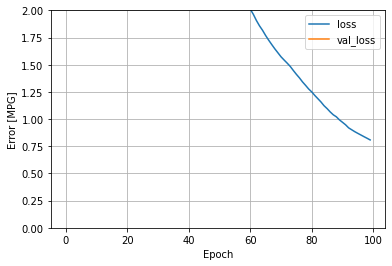

In [48]:
small = DNN_Pipeline(small_model())

        loss  val_loss        lr  epoch
90  0.047147  1.635966  0.000983     90
91  0.050180  1.634680  0.000983     91
92  0.050739  1.641111  0.000983     92
93  0.046842  1.652243  0.000983     93
94  0.040250  1.672774  0.000983     94
95  0.044875  1.692291  0.000983     95
96  0.058620  1.667689  0.000982     96
97  0.054922  1.646033  0.000982     97
98  0.036633  1.639997  0.000982     98
99  0.044899  1.618228  0.000982     99


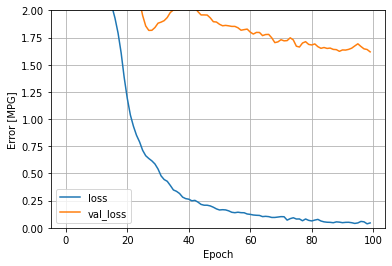

In [49]:
medium = DNN_Pipeline(medium_model())

        loss  val_loss        lr  epoch
90  0.095228  1.431781  0.000974     90
91  0.106969  1.432318  0.000974     91
92  0.087557  1.415256  0.000974     92
93  0.081974  1.394507  0.000974     93
94  0.074499  1.407943  0.000974     94
95  0.069178  1.406526  0.000974     95
96  0.072144  1.408143  0.000974     96
97  0.059668  1.413988  0.000974     97
98  0.066629  1.409001  0.000973     98
99  0.077801  1.391040  0.000973     99


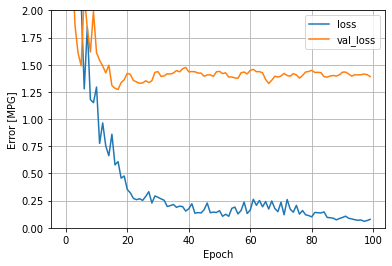

In [50]:
large = DNN_Pipeline(large_model())

        loss  val_loss        lr  epoch
90  0.444750  2.863687  0.000966     90
91  0.434115  2.866149  0.000965     91
92  0.425949  2.869004  0.000965     92
93  0.421723  2.862655  0.000965     93
94  0.414082  2.853852  0.000965     94
95  0.405743  2.850057  0.000965     95
96  0.400127  2.841501  0.000965     96
97  0.396171  2.838497  0.000965     97
98  0.392783  2.839187  0.000965     98
99  0.382278  2.839641  0.000965     99


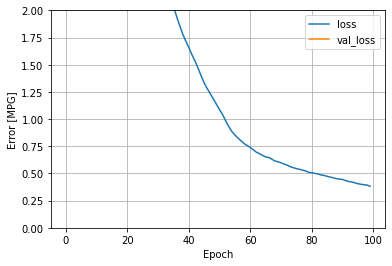

In [51]:
mikro = DNN_Pipeline(mikro_model())

        loss  val_loss        lr  epoch
90  0.283038  1.217157  0.000957     90
91  0.202350  1.155673  0.000957     91
92  0.272174  1.426000  0.000957     92
93  0.544695  1.170331  0.000957     93
94  0.323786  1.052741  0.000956     94
95  0.503543  1.416416  0.000956     95
96  0.463192  1.047154  0.000956     96
97  0.400499  1.135092  0.000956     97
98  0.258090  1.311830  0.000956     98
99  0.290427  1.145728  0.000956     99


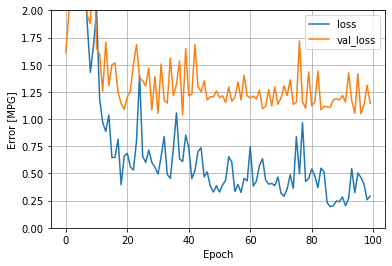

In [52]:
scale = DNN_Pipeline(scale_model())

In [54]:
mikro_predict = mikro.predict(test_features)
small_predict = small.predict(test_features)
medium_predict = medium.predict(test_features)
large_predict = large.predict(test_features)
scale_predict = scale.predict(test_features)

In [55]:
mean_absolute_error(mikro_predict,test_labels)   

2.622471519878933

In [56]:
mean_absolute_error(small_predict,test_labels)   

2.076182675361633

In [57]:
mean_absolute_error(medium_predict,test_labels)   

1.6991383382252283

In [58]:
mean_absolute_error(large_predict,test_labels)   

1.5293997628348213

In [59]:
mean_absolute_error(scale_predict,test_labels)   

1.3985192298889157

In [60]:
print(scale_predict)

[[ 8.107185 ]
 [ 9.311827 ]
 [ 7.83308  ]
 [14.881338 ]
 [ 6.457829 ]
 [ 8.543652 ]
 [ 8.146742 ]
 [ 6.5769677]
 [ 7.2236543]
 [ 8.296621 ]
 [ 7.1872745]
 [11.144028 ]
 [ 8.646872 ]
 [10.382212 ]
 [ 7.010115 ]
 [ 8.258173 ]
 [ 8.567742 ]
 [ 8.375925 ]
 [ 8.386982 ]
 [ 9.675667 ]
 [10.93867  ]
 [ 7.9659348]
 [ 7.6256204]
 [11.379206 ]
 [ 8.3647375]
 [ 9.2596855]
 [ 7.2582545]
 [12.150887 ]]


In [61]:
print (test_labels)

61    8.5
62    8.6
63    8.6
64    8.8
65    8.3
66    8.2
67    8.5
68    8.6
69    8.5
70    8.7
71    8.9
72    8.8
73    8.3
74    8.4
75    8.6
76    9.0
77    8.5
78    8.2
79    8.7
80    8.4
81    8.0
82    8.5
83    8.1
84    7.9
85    8.9
86    7.8
87    8.4
88    8.3
Name: Rating, dtype: float64


In [62]:
print(medium.predict(train_features))

[[ 8.845022 ]
 [ 8.780714 ]
 [ 8.500307 ]
 [ 8.890968 ]
 [ 8.971302 ]
 [ 8.550903 ]
 [ 8.610606 ]
 [ 8.582857 ]
 [ 8.871997 ]
 [ 8.766136 ]
 [ 8.666407 ]
 [ 8.094377 ]
 [ 8.1066   ]
 [ 8.697482 ]
 [ 8.494536 ]
 [ 8.462084 ]
 [ 8.552893 ]
 [ 8.711286 ]
 [ 8.495783 ]
 [ 8.844618 ]
 [ 8.603128 ]
 [ 8.51959  ]
 [ 8.519227 ]
 [ 8.570186 ]
 [ 8.269288 ]
 [ 8.648451 ]
 [ 9.0367775]
 [ 8.519227 ]
 [ 8.889872 ]
 [ 8.326539 ]
 [ 8.53756  ]
 [ 8.748127 ]
 [ 8.535123 ]
 [ 8.691801 ]
 [ 8.654772 ]
 [ 8.606838 ]
 [ 8.54561  ]
 [ 8.898199 ]
 [ 8.480509 ]
 [ 8.727413 ]
 [ 8.530682 ]
 [ 8.653105 ]
 [ 8.662506 ]
 [ 8.4443035]
 [ 8.5266285]
 [ 8.947819 ]
 [ 8.670475 ]
 [ 8.490593 ]
 [ 7.360883 ]
 [ 8.392466 ]
 [ 6.071138 ]
 [ 6.071138 ]
 [ 7.7653646]
 [ 7.2642627]
 [ 6.9697213]
 [ 6.635562 ]
 [ 4.893934 ]
 [ 7.0373755]
 [12.685125 ]
 [ 7.8719134]
 [ 9.08442  ]]


# RANGKING WITH REGRESSION

In [83]:
a = []

for x in range(1,90):
    a.append(x)
    
print(a)

df2 = df
df2['Rank'] = a

df2

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]


,Star,Rating,Reviews,Harga,Shuttle Service,Sports and Recreations,Kids and Pets,Transportation,Connectivity,Accessibilty,...,Sport,Quick Bites,Education,Street Food,Activity & Games,Cafe,Entertainment,Food Court,Sight & Landmark,Rank
0,5.0,8.9,4363,2480500,2.0,3.0,4.0,4.0,5.0,6.0,...,10000,10000,10000,10000,10000,10000,10000,10000,10000,1
1,5.0,8.8,238,3823600,0.0,2.0,3.0,4.0,3.0,0.0,...,10000,10000,10000,10000,10000,10000,10000,10000,10000,2
2,5.0,8.5,8405,6231500,2.0,3.0,3.0,7.0,6.0,8.0,...,10000,10000,10000,10000,10000,10000,10000,10000,10000,3
3,4.0,8.9,424,762300,0.0,2.0,0.0,3.0,0.0,3.0,...,10000,10000,10000,10000,10000,10000,10000,10000,10000,4
4,5.0,9.0,393,1756254,2.0,3.0,7.0,6.0,3.0,0.0,...,10000,10000,10000,10000,10000,10000,10000,10000,10000,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,2.0,7.9,11026,385200,2.0,0.0,0.0,4.0,3.0,3.0,...,10000,10000,10000,10000,10000,10000,10000,10000,10000,85
85,5.0,8.9,1511,2420000,2.0,0.0,0.0,8.0,3.0,8.0,...,10000,10000,10000,10000,10000,10000,10000,10000,10000,86
86,4.0,7.8,517,688000,0.0,0.0,0.0,0.0,3.0,0.0,...,10000,10000,10000,10000,10000,10000,10000,10000,10000,87
87,4.0,8.4,2717,431250,2.0,3.0,0.0,5.0,4.0,3.0,...,10000,10000,10000,10000,10000,10000,10000,10000,10000,88


In [84]:
train_dataset = df2.loc[:70]
test_dataset = df2.drop(train_dataset.index)

train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('Rank')
test_labels = test_features.pop('Rank')

In [87]:
normalizer2 = tf.keras.layers.Normalization(axis=-1)
normalizer2.adapt(np.array(train_features))
print(normalizer.mean.numpy())

[[4.2816901e+00 8.5873232e+00 2.4317466e+03 1.7277068e+06 1.7887324e+00
  2.7323942e+00 1.3239436e+00 4.5492959e+00 3.9577465e+00 3.8450704e+00
  6.7042251e+00 8.3380280e+00 1.1408450e+01 6.2394366e+00 6.6478872e+00
  9.4084511e+00 1.2000000e+01 1.1605634e+01 9.5789727e+03 2.8839155e+03
  3.0320562e+03 3.7190706e+03 2.1346338e+03 9.8607891e+03 9.5860977e+03
  7.4591831e+03 9.3296055e+03 9.4377754e+03 9.7351133e+03 9.8595781e+03
  8.7858164e+03 9.7189004e+03 9.5949570e+03 9.4380703e+03 9.7323945e+03
  9.8594512e+03 9.7262676e+03]]


        loss   val_loss        lr  epoch
90  0.519948  28.320362  0.000915     90
91  0.429413  28.266056  0.000915     91
92  0.544394  28.598274  0.000915     92
93  0.512881  28.489222  0.000914     93
94  0.424606  28.304314  0.000914     94
95  0.465886  28.442287  0.000914     95
96  0.426219  28.253700  0.000914     96
97  0.451739  28.411366  0.000914     97
98  0.409495  28.544901  0.000914     98
99  0.464673  28.430376  0.000914     99


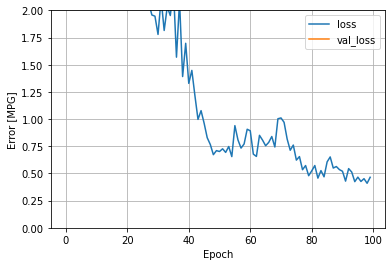

In [89]:
large = DNN_Pipeline(large_model(normalizer2))


        loss   val_loss        lr  epoch
90  0.838518  29.778086  0.000907     90
91  1.036288  29.615421  0.000906     91
92  1.053310  28.866970  0.000906     92
93  1.106821  29.836077  0.000906     93
94  1.256244  25.877136  0.000906     94
95  1.978358  31.316618  0.000906     95
96  2.461857  31.469374  0.000906     96
97  1.867874  26.021902  0.000906     97
98  2.337248  29.757627  0.000906     98
99  1.263864  30.567513  0.000906     99


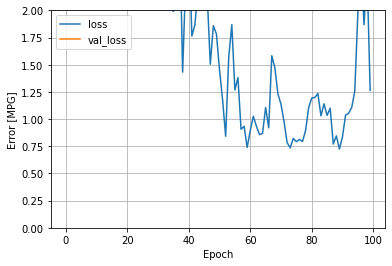

In [90]:
scale = DNN_Pipeline(scale_model(normalizer2))


        loss   val_loss        lr  epoch
90  1.135394  29.488733  0.000898     90
91  1.123194  29.343977  0.000898     91
92  1.121402  29.358667  0.000898     92
93  1.118168  29.363667  0.000898     93
94  1.099245  29.285042  0.000898     94
95  1.122275  29.351274  0.000898     95
96  1.077221  29.462938  0.000898     96
97  1.101633  29.403988  0.000898     97
98  1.087730  29.313591  0.000898     98
99  1.053681  29.348352  0.000898     99


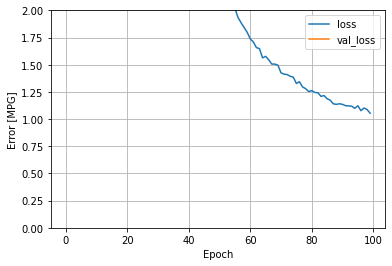

In [91]:
medium = DNN_Pipeline(medium_model(normalizer2))

In [97]:
df_rank = test_dataset
df_rank['score'] = medium.predict(test_features)
df_rank

,Star,Rating,Reviews,Harga,Shuttle Service,Sports and Recreations,Kids and Pets,Transportation,Connectivity,Accessibilty,...,Quick Bites,Education,Street Food,Activity & Games,Cafe,Entertainment,Food Court,Sight & Landmark,Rank,score
71,5.0,8.9,2206,2481690,0.0,5.0,3.0,3.0,2.0,3.0,...,10000,10000,10000,10000,10000,10000,10000,10000,72,15.937734
72,3.0,8.8,10851,454400,3.0,2.0,0.0,3.0,3.0,0.0,...,10000,10000,10000,10000,10000,10000,10000,10000,73,14.342639
73,3.0,8.3,6238,1144000,6.0,5.0,0.0,5.0,4.0,5.0,...,10000,10000,10000,909,10000,10000,10000,10000,74,35.689827
74,4.0,8.4,1775,1486290,2.0,10.0,6.0,3.0,0.0,7.0,...,10000,10000,10000,10000,10000,10000,10000,10000,75,21.647861
75,4.0,8.6,8882,540346,2.0,3.0,0.0,4.0,4.0,4.0,...,10000,10000,10000,10000,10000,10000,10000,10000,76,20.628439
76,5.0,9.0,1983,4501200,2.0,3.0,3.0,8.0,5.0,3.0,...,10000,10000,10000,10000,10000,10000,10000,10000,77,12.692438
77,4.0,8.5,4929,468300,3.0,7.0,0.0,0.0,3.0,0.0,...,10000,10000,10000,10000,10000,10000,10000,10000,78,15.104996
78,4.0,8.2,4540,650000,0.0,0.0,3.0,4.0,3.0,2.0,...,10000,10000,10000,10000,10000,10000,10000,10000,79,29.120211
79,4.0,8.7,614,950000,0.0,0.0,0.0,0.0,3.0,4.0,...,10000,10000,10000,10000,10000,10000,10000,10000,80,33.163113
80,3.0,8.4,5052,688710,0.0,0.0,0.0,0.0,4.0,4.0,...,10000,526,10000,10000,29,10000,10000,10000,81,38.663925


In [110]:
new_sorted = df_rank.sort_values(by=['score'])

# RANk error per item (0 is perfect)

In [113]:
b = []

for x in range (72,90):
    b.append(x)

    
c = b-(new_sorted['Rank'])

print (c)

76    -5
72     0
77    -4
71     3
75     0
74     2
81    -4
84    -6
88    -9
85    -5
87    -6
82     0
78     5
79     5
73    12
83     3
80     7
86     2
Name: Rank, dtype: int64


In [104]:
print(df_rank.index)

RangeIndex(start=71, stop=89, step=1)


In [94]:
test_labels

71    72
72    73
73    74
74    75
75    76
76    77
77    78
78    79
79    80
80    81
81    82
82    83
83    84
84    85
85    86
86    87
87    88
88    89
Name: Rank, dtype: int64

## Rank Train Datasets

In [117]:
# Rank train datasets

medium.predict(train_features)

array([[ 0.98193693],
       [ 1.9481711 ],
       [ 2.9329703 ],
       [ 3.8960855 ],
       [ 6.393463  ],
       [ 5.8471518 ],
       [ 7.0787992 ],
       [ 7.987013  ],
       [ 9.322394  ],
       [ 9.824222  ],
       [10.883415  ],
       [14.869306  ],
       [12.837362  ],
       [13.90597   ],
       [15.080946  ],
       [17.402279  ],
       [17.379236  ],
       [17.945894  ],
       [18.836735  ],
       [20.02751   ],
       [20.935183  ],
       [21.927853  ],
       [24.790613  ],
       [24.015165  ],
       [24.94504   ],
       [24.926788  ],
       [26.829065  ],
       [24.790613  ],
       [28.989336  ],
       [29.891573  ],
       [30.976261  ],
       [32.113525  ],
       [32.932922  ],
       [34.062344  ],
       [34.65907   ],
       [36.152763  ],
       [27.499323  ],
       [37.82648   ],
       [39.002014  ],
       [39.808315  ],
       [40.856865  ],
       [41.909107  ],
       [42.818474  ],
       [43.945274  ],
       [45.620064  ],
       [46

In [118]:
df_rank = train_dataset
df_rank['score'] = medium.predict(train_features)
df_rank
new_sorted2 = df_rank.sort_values(by=['score'])
new_sorted2

/tmp/ipykernel_905460/3931622530.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rank['score'] = medium.predict(train_features)


,Star,Rating,Reviews,Harga,Shuttle Service,Sports and Recreations,Kids and Pets,Transportation,Connectivity,Accessibilty,...,Quick Bites,Education,Street Food,Activity & Games,Cafe,Entertainment,Food Court,Sight & Landmark,Rank,score
0,5.0,8.9,4363,2480500,2.0,3.0,4.0,4.0,5.0,6.0,...,10000,10000,10000,10000,10000,10000,10000,10000,1,0.981937
1,5.0,8.8,238,3823600,0.0,2.0,3.0,4.0,3.0,0.0,...,10000,10000,10000,10000,10000,10000,10000,10000,2,1.948171
2,5.0,8.5,8405,6231500,2.0,3.0,3.0,7.0,6.0,8.0,...,10000,10000,10000,10000,10000,10000,10000,10000,3,2.932970
3,4.0,8.9,424,762300,0.0,2.0,0.0,3.0,0.0,3.0,...,10000,10000,10000,10000,10000,10000,10000,10000,4,3.896086
5,5.0,8.6,18892,820000,2.0,3.0,3.0,6.0,9.0,8.0,...,10000,10000,10000,10000,10000,10000,10000,10000,6,5.847152
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52,3.0,8.5,7,570000,4.0,3.0,0.0,5.0,4.0,0.0,...,10000,10000,10000,10000,10000,10000,10000,10000,53,53.140404
53,4.0,8.0,5,475000,0.0,9.0,0.0,4.0,3.0,0.0,...,10000,142,10000,10000,10000,10000,10000,10000,54,53.982285
54,5.0,8.2,61,1283013,0.0,0.0,0.0,0.0,5.0,8.0,...,10000,10000,10000,10000,10000,10000,10000,10000,55,54.875778
55,4.0,8.3,10,530000,0.0,0.0,0.0,4.0,5.0,3.0,...,10000,10000,10000,501,10000,10000,10000,10000,56,56.022690


# RANk error per item (0 is perfect)

In [122]:
K = []

for x in range (1,72):
    K.append(x)

    
c = K-(new_sorted2['Rank'])

for x in c:
    print (x)

0
0
0
0
-1
1
0
0
0
0
0
-1
-1
2
0
-1
1
-52
1
-49
2
2
2
2
1
-45
-1
5
3
5
-37
5
-4
5
-31
6
6
-11
7
-21
8
-5
9
9
-17
-11
-18
12
-14
12
-13
13
13
13
13
-2
14
-2
15
15
15
-5
15
14
14
14
14
14
14
14
12
